In [2]:
%matplotlib inline
import imageio
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd

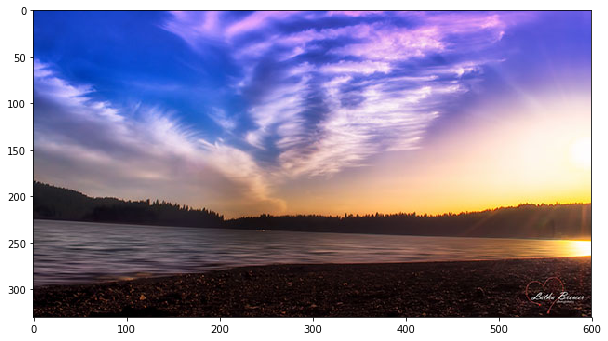

In [2]:
image = imageio.imread("smallsunset.jpg")
plt.figure(figsize=(10,10))
plt.imshow(image)

# Part A

In [18]:
def EM_Algorithm(image, segment, cov_flag):
    
    width = image.shape[0]
    height = image.shape[1]
    
    def rescale(image):
        for i in range(width):
            for j in range(height):
                image[i][j] = (image[i][j])/255
        return image

    def descale(weights, mu):
        image = []
        weights = np.array(weights)
        for p in weights:
            pixel = np.argsort(p)[segment-1]
            image.append([i * 255 for i in mu[pixel]])
        image = np.array(image).reshape(width, height, 3)
        image = image.astype(np.int)
        return image

    def getPDF(image, mean, covmat):
        norm = multivariate_normal(mean = mean, cov = covmat)
        return norm.pdf(image)

    def flatten(image):
        return image.flatten().reshape((width * height), 3)
    
    def E_Step(image, num_pixels, num_features, mu, cov, pi):
        weights = np.zeros((num_pixels, segment))
        weights = np.mat(weights)
        pdf = np.zeros((num_pixels, segment))
        for i in range(segment):
            pdf[:, i] = getPDF(image, mu[i], cov[i])
        pdf = np.mat(pdf)
        for i in range(segment):
            weights[:, i] = pi[i] * pdf[:, i]
        for i in range(num_pixels):
            weights[i, :] = weights[i, :]/np.sum(weights[i, :])
        return weights
    
    def M_Step(image, weights, num_pixels, num_features):
        pi = np.zeros(segment)
        mu = np.zeros((segment, num_features))
        for i in range(segment):
            weight_sum = np.sum(weights[:, i])
            pi[i] = weight_sum/num_pixels
            for j in range(num_features):
                weight_update = 0
                for k in range(num_pixels):
                    weight_update += weights[k, i] * image[k, j]
                mu[i, j] = weight_update/weight_sum
        return mu, pi
    
    image = rescale(image)
    image = flatten(image)
    
    num_pixels, num_features = image.shape
    cov = np.zeros((segment, num_features, num_features))
    if (cov_flag == 0):
        cov = np.array([np.eye(num_features)] * segment)
    elif (cov_flag == 1):
        cov = np.array([np.eye(num_features) * (1/400)] * segment)
    elif (cov_flag == 2):
        cov = np.array([np.cov(np.array(image).T)] * segment)
    kmeans = KMeans(n_clusters = segment, random_state = 498).fit(image)
    pi = np.zeros(segment)
    for i in range(segment):
        pi[i] = float(np.sum(kmeans.labels_ == i, axis = 0))/num_pixels
    mu = kmeans.cluster_centers_
    
    for i in range(10):
        mu_prev = mu
        weights = E_Step(image, num_pixels, num_features, mu, cov, pi)
        mu, pi = M_Step(image, weights, num_pixels, num_features)
        if abs(np.sum(mu_prev) - np.sum(mu)) < 0.01:
            break
    image = descale(weights, mu)
    return image

In [66]:
images = []
segments = [10, 20, 50]
for segment in segments:
    image = imageio.imread("smallsunset.jpg")
    image = image.astype(np.float32)
    image_s = EM_Algorithm(image, segment, 0)
    images.append(image_s)

Text(0.5,1,'Segment 50')

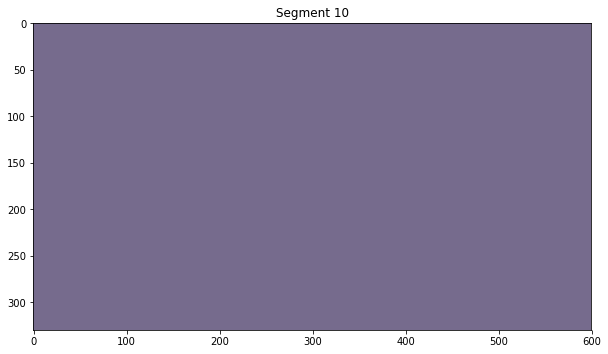

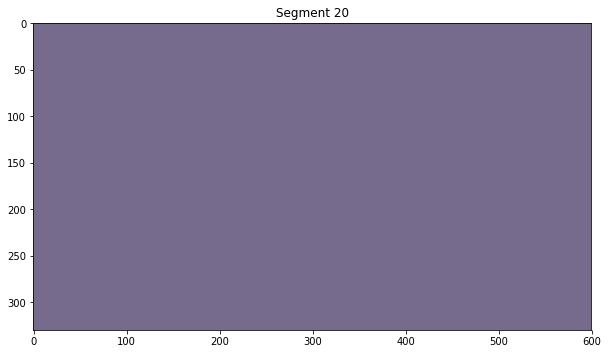

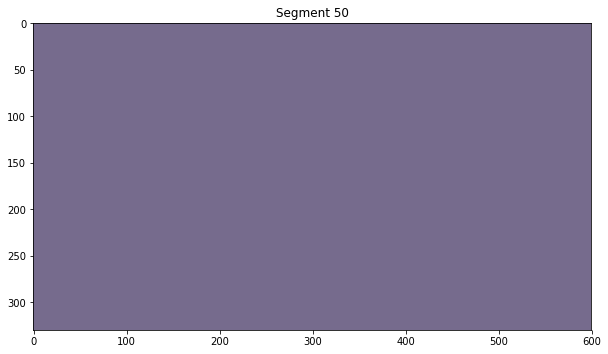

In [68]:
plt.figure(figsize=(10,10))
plt.imshow(images[0])
plt.title("Segment 10")

plt.figure(figsize=(10,10))
plt.imshow(images[1])
plt.title("Segment 20")

plt.figure(figsize=(10,10))
plt.imshow(images[2])
plt.title("Segment 50")

Here we can see that all the pixels ended up into one cluster. All the images eventually have the same color regardless of the segment number. This is due to the clusters drifting towards one another to form into one

# Part B

In [16]:
def EM_Algorithm_B(image, cov_flag):

    width = image.shape[0]
    height = image.shape[1]
    segment = 10
    
    def rescale(image):
        for i in range(width):
            for j in range(height):
                image[i][j] = (image[i][j])/255
        return image

    def getPDF(image, mean, covmat):
        norm = multivariate_normal(mean = mean, cov = covmat)
        return norm.pdf(image)

    def flatten(image):
        return image.flatten().reshape((width * height), 3)
    
    def E_Step(image, num_pixels, num_features, mu, cov, pi):
        weights = np.zeros((num_pixels, segment))
        weights = np.mat(weights)
        pdf = np.zeros((num_pixels, segment))
        for i in range(segment):
            pdf[:, i] = getPDF(image, mu[i], cov[i])
        pdf = np.mat(pdf)
        for i in range(segment):
            weights[:, i] = pi[i] * pdf[:, i]
        for i in range(num_pixels):
            weights[i, :] = weights[i, :]/np.sum(weights[i, :])
        return weights
    
    def M_Step(image, weights, num_pixels, num_features):
        pi = np.zeros(segment)
        mu = np.zeros((segment, num_features))
        for i in range(segment):
            weight_sum = np.sum(weights[:, i])
            pi[i] = weight_sum/num_pixels
            for j in range(num_features):
                weight_update = 0
                for k in range(num_pixels):
                    weight_update += weights[k, i] * image[k, j]
                mu[i, j] = weight_update/weight_sum
        return mu, pi
    
    image = rescale(image)
    image = flatten(image)
    
    num_pixels, num_features = image.shape
    cov = np.zeros((segment, num_features, num_features))
    if (cov_flag == 0):
        cov = np.array([np.eye(num_features)] * segment)
    elif (cov_flag == 1):
        cov = np.array([np.eye(num_features) * (1/400)] * segment)
    elif (cov_flag == 2):
        cov = np.array([np.cov(np.array(image).T)] * segment)
    kmeans = KMeans(n_clusters = segment, random_state = 498).fit(image)
    pi = np.zeros(segment)
    for i in range(segment):
        pi[i] = float(np.sum(kmeans.labels_ == i, axis = 0))/num_pixels
    mu = kmeans.cluster_centers_
    
    weights = E_Step(image, num_pixels, num_features, mu, cov, pi)
    mu, pi = M_Step(image, weights, num_pixels, num_features)
    weight_links = np.array(weights)
    weight_links = weight_links.reshape(width, height, 10)
    weight_links = weight_links.transpose(2, 0, 1)
    
    plt.figure(figsize=(5,5))
    plt.imshow(weight_links[0])
    plt.title("Cluster 1")
    plt.figure(figsize=(5,5))
    plt.imshow(weight_links[1])
    plt.title("Cluster 2")
    plt.figure(figsize=(5,5))
    plt.imshow(weight_links[2])
    plt.title("Cluster 3")
    plt.figure(figsize=(5,5))
    plt.imshow(weight_links[3])
    plt.title("Cluster 4")
    plt.figure(figsize=(5,5))
    plt.imshow(weight_links[4])
    plt.title("Cluster 5")
    plt.figure(figsize=(5,5))
    plt.imshow(weight_links[5])
    plt.title("Cluster 6")
    plt.figure(figsize=(5,5))
    plt.imshow(weight_links[6])
    plt.title("Cluster 7")
    plt.figure(figsize=(5,5))
    plt.imshow(weight_links[7])
    plt.title("Cluster 8")
    plt.figure(figsize=(5,5))
    plt.imshow(weight_links[8])
    plt.title("Cluster 9")
    plt.figure(figsize=(5,5))
    plt.imshow(weight_links[9])
    plt.title("Cluster 10")

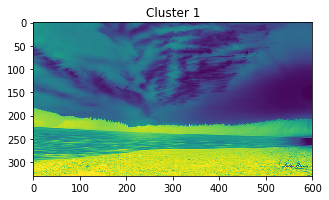

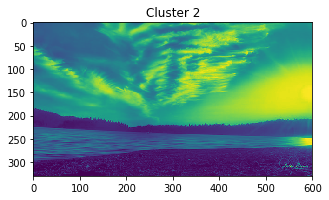

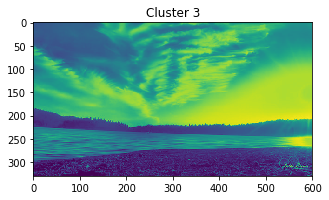

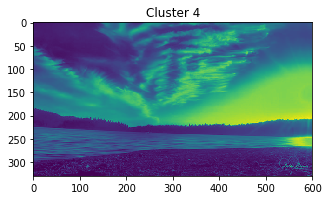

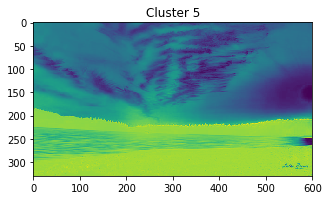

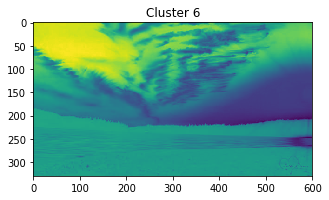

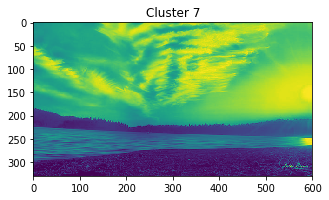

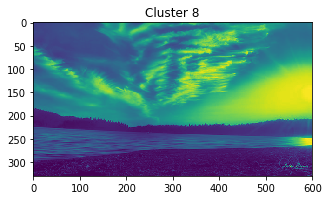

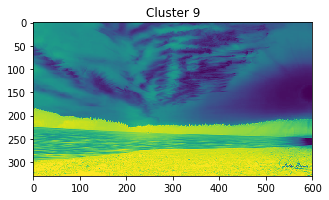

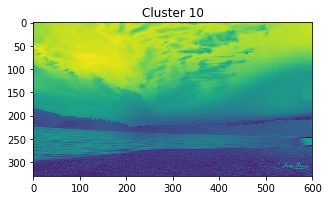

In [85]:
image = imageio.imread("smallsunset.jpg")
image = image.astype(np.float32)
EM_Algorithm_B(image, 0)

We see that the weights still take on the form of the original image, but with different scaled pixels. We probably don't see much change because our covariance is the identity matrix, so pixels that are similar to one another won't vary greatly.

# Part C

In [87]:
images = []
segments = [10, 20, 50]
for segment in segments:
    image = imageio.imread("smallsunset.jpg")
    image = image.astype(np.float32)
    image_s = EM_Algorithm(image, segment, 1)
    images.append(image_s)

Text(0.5,1,'Segment 50')

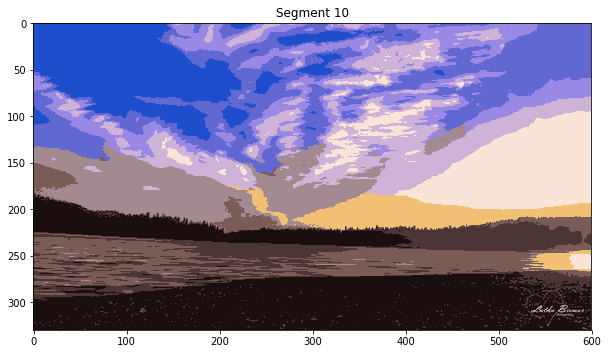

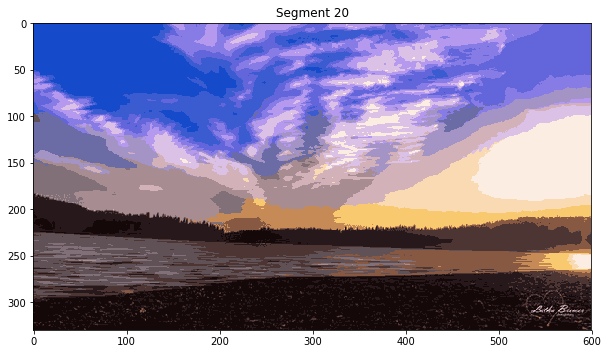

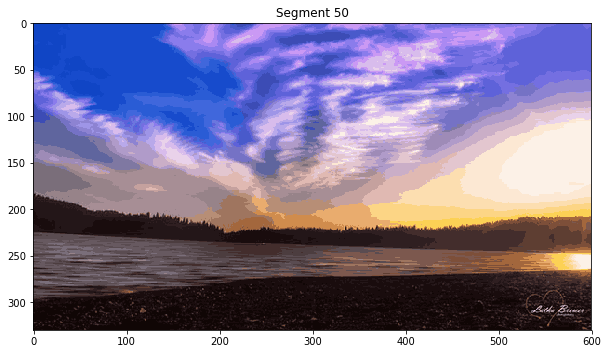

In [88]:
plt.figure(figsize=(10,10))
plt.imshow(images[0])
plt.title("Segment 10")

plt.figure(figsize=(10,10))
plt.imshow(images[1])
plt.title("Segment 20")

plt.figure(figsize=(10,10))
plt.imshow(images[2])
plt.title("Segment 50")

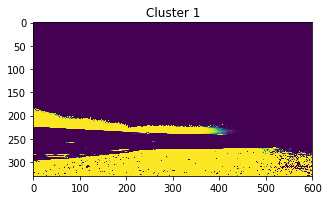

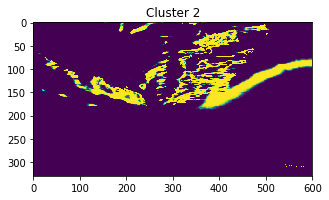

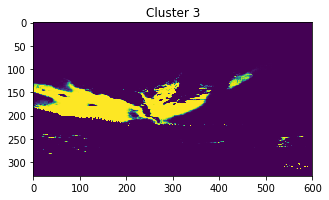

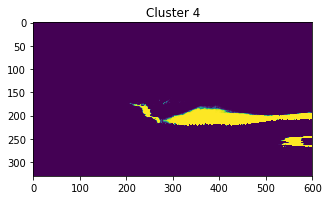

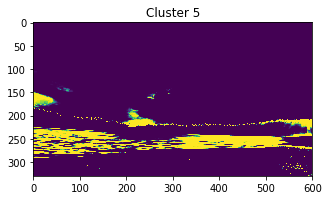

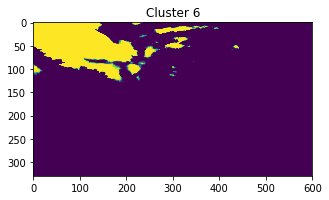

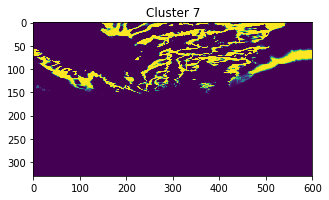

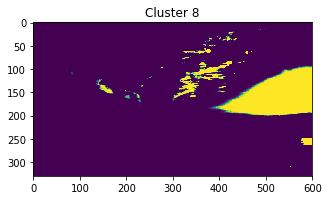

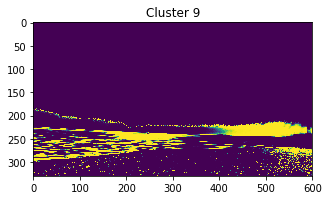

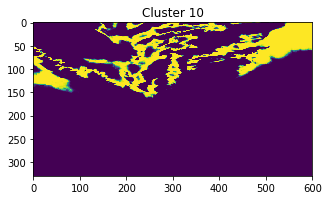

In [89]:
image = imageio.imread("smallsunset.jpg")
image = image.astype(np.float32)
EM_Algorithm_B(image, 1)

In our three segmented photos we now have images looking similar to our original. We can see that the more segments to more details we can see in the images. This means that the clusters are drifting apart from one another. For the weight images we see that there are variances between the different cluster images, with the covaraiance no longer being the identity we can now see changes within the weights visually.

# Part D

In [19]:
images = []
segments = [10, 20, 50]
for segment in segments:
    image = imageio.imread("smallsunset.jpg")
    image = image.astype(np.float32)
    image_s = EM_Algorithm(image, segment, 2)
    images.append(image_s)

Text(0.5,1,'Segment 50')

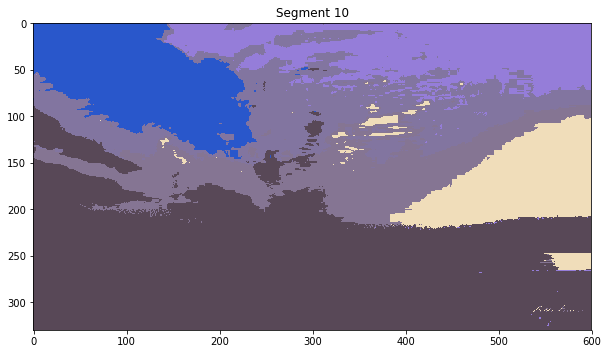

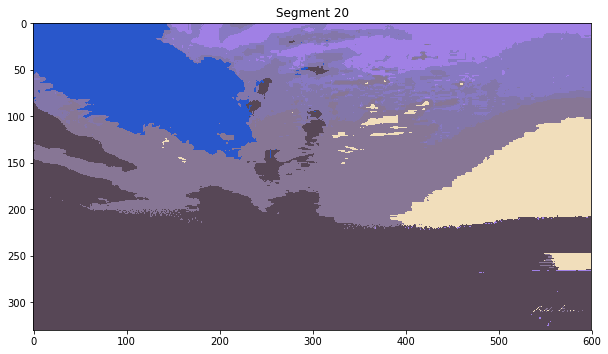

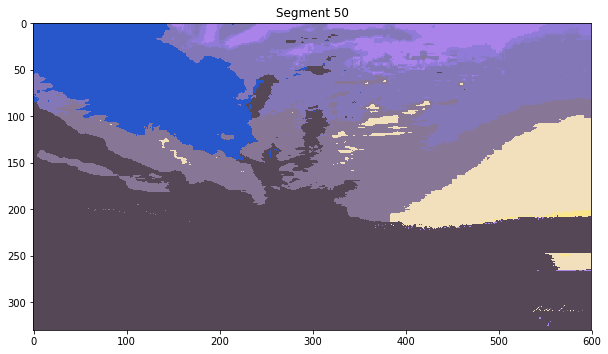

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(images[0])
plt.title("Segment 10")

plt.figure(figsize=(10,10))
plt.imshow(images[1])
plt.title("Segment 20")

plt.figure(figsize=(10,10))
plt.imshow(images[2])
plt.title("Segment 50")

Here we see that our segmented images are less accurate than those from Part C, but better than that of Part A. In the different segments we see that as the number of segments increase the more the clusters start to drift apart.